# Importaciones para el proyecto:

In [2]:
import sys
import os
print(os.getcwd())
sys.path.append(os.path.abspath("../"))

c:\Users\lukat\BOOTCAMPASUS\ML_Adidas-Forecast\src\results_notebook


In [3]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

import utils.bootcampviztools as bt
import utils.funciones_eda as fe
import utils.toolbox_ML as tb


Paquete utils cargado correctamente


# ✅ Step 1: Objetivo del proyecto.


### ADIDAS Y SUS DISTRIBUIDORES EN UNITED STATES. 🔎

Adidas quiere saber una predicción razonable de cuánto facturarán las tiendas distribuidoras para asi saber si los productos que solicitan son adecuados a su nivel de facturación. Es muy importante que el producto esté en el lugar más eficiente posible y para ello debemos predecirlo.

A su vez, quieren plantear un sistema logístico para los Estados de USA donde haya más demanda de producto. Considerando asi una prevención a la rotura de stock y a la mejora en costes ya que el producto más vendido en cada Estado estaría más cerca de dichas tiendas distribuidoras.

🤔 PREGUNTAS QUE NOS HACEMOS 🤔

A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS 💵 (pt. I)

B. PREVENCIÓN A LA ROTURA DE STOCK E INVESTIGACIÓN DE MERCADO 🚛 (pt. II)
- ¿Qué mercado es el que está en auge para estos años?
- ¿Hay algún mercado que debamos conocer que vaya en declive?
- ¿Cumplirán las tiendas con el mínimo de facturación deseable?
- ¿Varía la facturación con la estacionalidad?
- ¿En qué regiones debemos tener un centro logístico más potente para el futuro?
- ¿Cuánto stock por categoría deberá estar disponible en cada región?

🙋‍♂️ *El proyecto contiene **dos partes**. Al ser un proyecto extenso, la primera parte **(A)** será la entregada para calificar. La parte II **(B)** se contestará en las próximas semanas de forma personal.*

👁‍🗨 *El papel de "Negocio" es muy importante en este proyecto. Hay muchos matices que dependiendo de lo que "Negocio" crea conveniente, se haría de una forma u otra.*

# ✅ Step 2: Obtener datos.


In [4]:
file_path = "../data/adidas_sales.csv"

In [5]:
df = pd.read_csv(file_path)
df.head(5)

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Sales Method
0,Walmart,1128299,6/17/2021,Southeast,Florida,Orlando,Women's Apparel,$103.00,218,"2,245","$1,257",Online
1,West Gear,1128299,7/16/2021,South,Louisiana,New Orleans,Women's Apparel,$103.00,163,"1,679",$806,Online
2,Sports Direct,1197831,8/25/2021,South,Alabama,Birmingham,Men's Street Footwear,$10.00,700,"7,000","$3,150",Outlet
3,Sports Direct,1197831,8/27/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,575,"8,625","$3,881",Outlet
4,Sports Direct,1197831,8/21/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,475,"7,125","$3,206",Outlet


---------
A simple vista vemos:
- Columnas espaciadas.
- Error en el cálculo de ***"Total Sales"***
- Columnas que vamos a limpiar para tener el DataFrame lo más funcional posible.

Y más cosas que veremos en el siguiente paso

# ✅ Step 3: Limpieza de datos - Correcciones - Target.


- Solucionamos las columnas espaciadas:

In [6]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   retailer          9641 non-null   object
 1   retailer_id       9641 non-null   int64 
 2   invoice_date      9641 non-null   object
 3   region            9641 non-null   object
 4   state             9641 non-null   object
 5   city              9641 non-null   object
 6   product           9641 non-null   object
 7   price_per_unit    9639 non-null   object
 8   units_sold        9641 non-null   object
 9   total_sales       9641 non-null   object
 10  operating_profit  9641 non-null   object
 11  sales_method      9641 non-null   object
dtypes: int64(1), object(11)
memory usage: 904.0+ KB


- Valores faltantes en ***"price_per_unit"*** pero antes solucionaremos el error de cálculo en ***"total_sales"***
- Tenemos tipo object en todas las columnas, debemos transformar a númericas algunas.
- Queremos transformar ***"invoice_date"*** en datetime.
- Vamos a eliminar columnas no relevantes al proyecto.

In [8]:
df[df.index == 78]

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
78,West Gear,1128299,1/12/2021,West,California,San Francisco,Men's Street Footwear,$41.00,338,"1,386",$527,Outlet


- Si vemos el *sample* podemos ver que la multiplicación en ***"total_sales"*** (*price_per_unit* y *units_sold*) no es correcta. Vamos a hacerla de nuevo y corregiremos el símbolo del dollar. La haremos tipo numérica. Por último añadiremos dos decimales en las columnas.

In [9]:
df["price_per_unit"] = df["price_per_unit"].str.replace("$", "")
df["price_per_unit"] = pd.to_numeric(df["price_per_unit"], errors="coerce")

In [10]:
# Visión general de los datos
df.sample(6)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
1004,Kohl's,1189833,4/15/2021,West,California,Los Angeles,Women's Street Footwear,36.0,215,774,$348,Outlet
2577,Amazon,1185732,2/12/2021,Northeast,Vermont,Burlington,Women's Athletic Footwear,40.0,150,"6,000","$2,100",In-store
7872,Amazon,1185732,9/10/2021,Northeast,Vermont,Burlington,Men's Street Footwear,60.0,525,"31,500","$14,175",In-store
8582,Walmart,1197831,4/20/2021,South,Arkansas,Little Rock,Women's Apparel,30.0,400,"12,000","$4,800",Online
7631,Kohl's,1189833,1/29/2021,Midwest,Montana,Billings,Women's Street Footwear,45.0,550,"24,750","$11,138",Outlet
8488,West Gear,1128299,6/21/2020,West,Washington,Seattle,Women's Street Footwear,65.0,400,"26,000","$6,500",In-store


In [11]:
df["units_sold"] = pd.to_numeric(df["units_sold"].str.replace(",", ""),errors="coerce")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retailer          9641 non-null   object 
 1   retailer_id       9641 non-null   int64  
 2   invoice_date      9641 non-null   object 
 3   region            9641 non-null   object 
 4   state             9641 non-null   object 
 5   city              9641 non-null   object 
 6   product           9641 non-null   object 
 7   price_per_unit    9639 non-null   float64
 8   units_sold        9641 non-null   int64  
 9   total_sales       9641 non-null   object 
 10  operating_profit  9641 non-null   object 
 11  sales_method      9641 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 904.0+ KB


Siendo columnas numéricas ya podríamos calcular el correcto "total_sales" pero vamos a visualizar los nulos primero antes de tocar los datos.

In [13]:
df[df.isnull().any(axis=1)]

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
6725,Foot Locker,1185732,1/29/2020,Northeast,New York,New York,Men's Apparel,NaN,850,"51,000","$15,300",Outlet
7882,Sports Direct,1197831,7/29/2020,South,Texas,Houston,Men's Apparel,NaN,500,"20,000","$6,000",Outlet


---------
🤔 Esto seria una pregunta para "Negocio" porque tenemos dos soluciones para afrontar estos nulos.
1. Entendemos que la división de ***"total_sales"*** / ***"units_sold"*** dan el resultado de ***"price_per_unit"***
2. Hemos visto que hay valores de ***"total_sales"*** que no fueron bien calculados y todos tienen en común la falta del último dígito.

Ya que son dos valores faltantes, vamos a confiar en los valores que tenemos del dataset y haremos la opción 1

In [14]:
df["total_sales"] = pd.to_numeric(df["total_sales"].str.replace(",", ""),errors="coerce")


In [15]:
df["price_per_unit"] = df["price_per_unit"].fillna(df["total_sales"] / df["units_sold"])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retailer          9641 non-null   object 
 1   retailer_id       9641 non-null   int64  
 2   invoice_date      9641 non-null   object 
 3   region            9641 non-null   object 
 4   state             9641 non-null   object 
 5   city              9641 non-null   object 
 6   product           9641 non-null   object 
 7   price_per_unit    9641 non-null   float64
 8   units_sold        9641 non-null   int64  
 9   total_sales       9641 non-null   int64  
 10  operating_profit  9641 non-null   object 
 11  sales_method      9641 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 904.0+ KB


- Calculamos los valores correctos de ***"total_sales"***

In [17]:
df["total_sales"] = df["price_per_unit"] * df["units_sold"]

In [18]:
df.sample(5)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
1391,Sports Direct,1185732,10/4/2021,Southeast,North Carolina,Charlotte,Men's Athletic Footwear,33.0,196,6468.0,$298,Online
6670,Walmart,1185732,4/22/2020,Northeast,New York,New York,Women's Athletic Footwear,50.0,900,45000.0,"$15,750",Outlet
2236,West Gear,1185732,3/8/2021,Northeast,New York,Albany,Women's Street Footwear,33.0,161,5313.0,$191,Online
2781,Foot Locker,1185732,1/24/2021,Northeast,New Hampshire,Manchester,Men's Street Footwear,52.0,145,7540.0,$347,Online
7532,West Gear,1185732,3/8/2021,Northeast,New York,Albany,Women's Street Footwear,35.0,575,20125.0,"$5,031",In-store


- Eliminamos las filas con resultado 0 en total_sales


In [19]:
df = df[df["total_sales"] != 0]

- DateTime para ***"invoice_date"*** y ordenamos el DataFrame

In [20]:
df["invoice_date"] = pd.to_datetime(df["invoice_date"])

In [21]:
df = df.sort_values(by="invoice_date")
df.head(8)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
9189,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.0,275,20625.0,"$6,188",Outlet
4937,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0,$141,Outlet
30,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0,$679,Outlet
4908,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0,$243,Online
79,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,47.0,336,15792.0,$963,Online
6562,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,60000.0,"$30,000",In-store
6588,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,50000.0,"$15,000",In-store
117,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,36.0,320,11520.0,$403,Outlet


In [22]:
df.isnull().sum()

retailer            0
retailer_id         0
invoice_date        0
region              0
state               0
city                0
product             0
price_per_unit      0
units_sold          0
total_sales         0
operating_profit    0
sales_method        0
dtype: int64

- Eliminamos columnas irrelevantes y hacemos una copia de seguridad del dataset

In [23]:
df = df.drop(columns=["retailer_id", "operating_profit", "sales_method"], errors="ignore")

# "retailer_id" se elimina porque ya tenemos una columna "retailer"
# "operation_profit" se elimina porque no tenemos contexto sobre los gastos para entender realmente el profit
# "sales_method" se elimina porque hemos entendido que son tiendas fisicas todas

- Una vista rápida para saber si está todo en orden

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9637 entries, 9189 to 9605
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   retailer        9637 non-null   object        
 1   invoice_date    9637 non-null   datetime64[ns]
 2   region          9637 non-null   object        
 3   state           9637 non-null   object        
 4   city            9637 non-null   object        
 5   product         9637 non-null   object        
 6   price_per_unit  9637 non-null   float64       
 7   units_sold      9637 non-null   int64         
 8   total_sales     9637 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 752.9+ KB


In [25]:
df.region.value_counts()

region
West         2446
Northeast    2376
Midwest      1865
South        1726
Southeast    1224
Name: count, dtype: int64

In [26]:
df.state.value_counts()

state
Texas             430
California        430
Florida           360
New York          360
Pennsylvania      216
Arkansas          216
Oklahoma          216
Rhode Island      216
Oregon            216
Virginia          216
Vermont           216
Mississippi       216
Idaho             216
Utah              216
New Hampshire     216
Arizona           216
Tennessee         216
Massachusetts     216
New Mexico        216
Alabama           216
Nevada            216
Connecticut       216
Georgia           216
Louisiana         216
Kentucky          144
Colorado          144
Washington        144
West Virginia     144
Wyoming           144
Minnesota         144
Montana           144
Iowa              144
Ohio              144
North Dakota      144
Alaska            144
Wisconsin         144
Michigan          144
Maryland          144
New Jersey        144
Indiana           144
Hawaii            144
South Dakota      144
Maine             144
North Carolina    144
Kansas            144
Miss

In [27]:
df.city.value_counts()

city
Portland          360
Charleston        288
Little Rock       216
New York          216
Boston            216
Oklahoma City     216
Providence        216
Richmond          216
Burlington        216
Philadelphia      216
Orlando           216
Jackson           216
Salt Lake City    216
Manchester        216
Phoenix           216
Los Angeles       216
Knoxville         216
Birmingham        216
Boise             216
Albuquerque       216
Dallas            216
Las Vegas         216
Hartford          216
Atlanta           216
New Orleans       216
Houston           214
San Francisco     214
Wilmington        144
Denver            144
Miami             144
Seattle           144
Cheyenne          144
Minneapolis       144
Billings          144
Des Moines        144
Columbus          144
Milwaukee         144
Fargo             144
Detroit           144
Baltimore         144
Indianapolis      144
Newark            144
Honolulu          144
Albany            144
Sioux Falls       144
Charl

In [28]:
df["product"].value_counts()

product
Men's Street Footwear        1610
Men's Athletic Footwear      1608
Women's Apparel              1607
Women's Street Footwear      1606
Men's Apparel                1604
Women's Athletic Footwear    1601
Men's aparel                    1
Name: count, dtype: int64

In [29]:
# Error de ortografía
df["product"] = df["product"].replace({"Men's aparel": "Men's Apparel"})
df["product"].value_counts()

product
Men's Street Footwear        1610
Men's Athletic Footwear      1608
Women's Apparel              1607
Women's Street Footwear      1606
Men's Apparel                1605
Women's Athletic Footwear    1601
Name: count, dtype: int64

In [30]:
df.retailer.value_counts()

retailer
Foot Locker      2630
West Gear        2372
Sports Direct    2030
Kohl's           1030
Amazon            949
Walmart           626
Name: count, dtype: int64

----------

- Vemos nuestro target ya habiendo limpiado nuestros nulos y recalculado el **"total_sales"**


<Axes: xlabel='total_sales', ylabel='Count'>

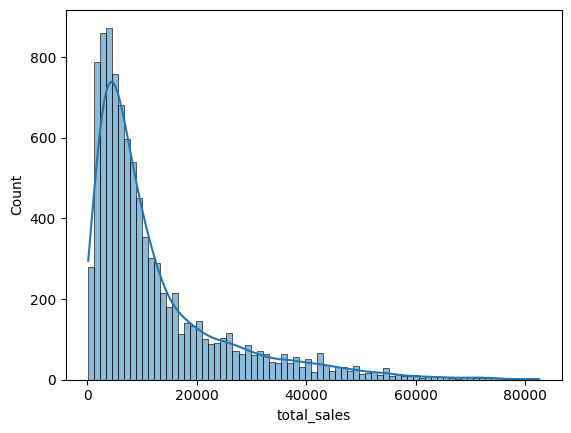

In [31]:
sns.histplot(df["total_sales"], kde = True)

<Axes: xlabel='total_sales'>

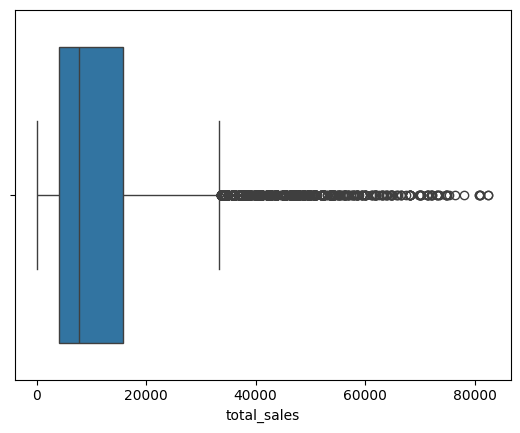

In [32]:
sns.boxplot(x=df["total_sales"])

- Esta bien que antes de comenzar a profundizar, veamos el tipo de target que tenemos. Hay una distribución asimétrica porque habrán muchas tiendas que tengan niveles bajos o moderados. Pocas tiendas logran grandes facturaciones o en pocas ocasiones lo logran.

- Nuestro modelo puede verse afectado por esta distribución asimetrica, debemos hacer una transformación logaritmica o box-cox más adelante.

---------

CREACION DE LOS DATASETS POR RETAILER

In [33]:
df["retailer"].value_counts()

retailer
Foot Locker      2630
West Gear        2372
Sports Direct    2030
Kohl's           1030
Amazon            949
Walmart           626
Name: count, dtype: int64

In [34]:
df_footlocker = df[df["retailer"] == "Foot Locker"]
df_westgear = df[df["retailer"] == "West Gear"]
df_sportsdirect = df[df["retailer"] == "Sports Direct"]
df_kohls = df[df["retailer"] == "Kohl's"]
df_amazon = df[df["retailer"] == "Amazon"]
df_walmart = df[df["retailer"] == "Walmart"]

In [35]:
# Comentamos el código para no ejecutarlo de nuevo, pero este sería el dataset limpiado
# df.to_csv("../data/adidas_sales_cleaned_last4.csv", index=False)

In [36]:
print("---Foot Locker---")
print(df_footlocker["total_sales"].describe())
print("---West Gear---")
print(df_westgear["total_sales"].describe())
print("---Sports Direct---")
print(df_sportsdirect["total_sales"].describe())
print("---Kohl's---")
print(df_kohls["total_sales"].describe())
print("---Amazon---")
print(df_amazon["total_sales"].describe())
print("---Walmart---")
print(df_walmart["total_sales"].describe())


---Foot Locker---
count     2630.000000
mean     11028.496198
std      12328.590997
min        160.000000
25%       3185.250000
50%       6689.500000
75%      13500.000000
max      76500.000000
Name: total_sales, dtype: float64
---West Gear---
count     2372.000000
mean     13624.708263
std      14074.800399
min        203.000000
25%       4263.750000
50%       8537.000000
75%      16855.500000
max      82500.000000
Name: total_sales, dtype: float64
---Sports Direct---
count     2030.000000
mean     12097.535468
std      11682.592391
min        528.000000
25%       4224.000000
50%       7522.000000
75%      15750.000000
max      69875.000000
Name: total_sales, dtype: float64
---Kohl's---
count     1030.000000
mean     13118.886408
std      11122.789865
min        520.000000
25%       5336.750000
50%       8243.000000
75%      20000.000000
max      52000.000000
Name: total_sales, dtype: float64
---Amazon---
count      949.000000
mean     10639.606955
std       9957.157975
min        416

- Todas las tiendas con su Dataset por si hay que utilizarlo:

In [37]:
# df_footlocker.to_csv("../data/adidas_sales_footlocker.csv", index=False)
# df_westgear.to_csv("../data/adidas_sales_westgear.csv", index=False)
# df_sportsdirect.to_csv("../data/adidas_sales_sportsdirect.csv", index=False)
# df_kohls.to_csv("../data/adidas_sales_kohls.csv", index=False)
# df_amazon.to_csv("../data/adidas_sales_amazon.csv", index=False)
# df_walmart.to_csv("../data/adidas_sales_walmart.csv", index=False)

# ✅ Step 4: Train y Test.


In [38]:
df_cleaned = pd.read_csv("../data/adidas_sales_cleaned_last4.csv", parse_dates=["invoice_date"], index_col=False)

In [39]:
df_cleaned

,retailer,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales
0,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.0,275,20625.0
1,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0
2,Foot Locker,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0
3,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0
4,Foot Locker,2020-01-01,Northeast,New York,New York,Men's Street Footwear,47.0,336,15792.0
...,...,...,...,...,...,...,...,...,...
9632,Foot Locker,2021-12-31,Northeast,Pennsylvania,Philadelphia,Men's Apparel,63.0,47,2961.0
9633,Amazon,2021-12-31,Northeast,Maine,Portland,Men's Apparel,55.0,125,6875.0
9634,Foot Locker,2021-12-31,Northeast,Pennsylvania,Philadelphia,Men's Apparel,46.0,56,2576.0
9635,Amazon,2021-12-31,Northeast,Maine,Portland,Men's Apparel,52.0,36,1872.0


In [40]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9637 entries, 0 to 9636
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   retailer        9637 non-null   object        
 1   invoice_date    9637 non-null   datetime64[ns]
 2   region          9637 non-null   object        
 3   state           9637 non-null   object        
 4   city            9637 non-null   object        
 5   product         9637 non-null   object        
 6   price_per_unit  9637 non-null   float64       
 7   units_sold      9637 non-null   int64         
 8   total_sales     9637 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 677.7+ KB


A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS

In [41]:
X = df_cleaned.drop(columns=["total_sales", "units_sold"])
y = df_cleaned["total_sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- A nuestra **X** le hemos quitado el target y ***"units_sold"*** porque no sabremos las unidades vendidas. He decidido dejar "price_per_unit" porque el precio por unidad si lo conocemos.

----------------

# ✅ Step 5: Mini Eda + Preparación del dataset


A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS

In [42]:
X_train.columns

Index(['retailer', 'invoice_date', 'region', 'state', 'city', 'product',
       'price_per_unit'],
      dtype='object')

- Conocemos las columnas de **X_train**
- Sumamos algunas columnas nuevas como ***"month"*** y ***"day_of_week"***
- Eliminamos columnas no relevantes

In [43]:
X_train["month"] = X_train["invoice_date"].dt.month
X_train["day_of_week"] = X_train["invoice_date"].dt.dayofweek  # Lunes=0, Domingo=6

X_test["month"] = X_test["invoice_date"].dt.month
X_test["day_of_week"] = X_test["invoice_date"].dt.dayofweek  # Lunes=0, Domingo=6

In [44]:
X_train = X_train.drop(columns=["invoice_date", "city", "units_sold"], errors="ignore")
X_test = X_test.drop(columns=["invoice_date", "city", "units_sold"], errors="ignore")

In [45]:
X_train

,retailer,region,state,product,price_per_unit,month,day_of_week
485,West Gear,Southeast,Florida,Men's Apparel,60.0,4,4
6472,Sports Direct,South,Texas,Men's Apparel,26.0,8,6
1222,Foot Locker,Midwest,Minnesota,Men's Apparel,35.0,12,1
5608,West Gear,Northeast,New York,Women's Apparel,66.0,7,3
2855,Kohl's,Midwest,Montana,Women's Apparel,55.0,3,1
...,...,...,...,...,...,...,...
5734,Kohl's,Midwest,Kansas,Men's Athletic Footwear,49.0,7,0
5191,Sports Direct,Midwest,Michigan,Women's Street Footwear,41.0,6,3
5390,West Gear,West,Oregon,Men's Apparel,86.0,6,3
860,Walmart,South,Texas,Men's Apparel,45.0,8,6


- Queremos hacer varios **X_train**, en este caso vamos a hacer un *Column Transform* para que nuestros modelos de **XGBoost** y **Random Forest** puedan trabajar mejor.

In [77]:
categorical_features = ['retailer', 'region', 'state', 'product', 'day_of_week', "month"]
numeric_features = ['price_per_unit']

In [47]:
preprocessor = ColumnTransformer(
     transformers=[
      ("num", "passthrough", numeric_features),
      ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)
ohe_columns_clean = np.char.replace(ohe_columns.astype(str), ' ', '_')
all_columns_clean = np.concatenate([numeric_features, ohe_columns_clean])

X_train_df = pd.DataFrame(X_train_preprocessed, columns=all_columns_clean, index=X_train.index)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=all_columns_clean, index=X_test.index)

In [48]:
X_train_df

,price_per_unit,retailer_Amazon,retailer_Foot_Locker,retailer_Kohl's,retailer_Sports_Direct,retailer_Walmart,retailer_West_Gear,region_Midwest,region_Northeast,region_South,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
485,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6472,26.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1222,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5608,66.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2855,55.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,49.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5191,41.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,86.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
860,45.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


- Visualizamos nuestro target en **y_train**

In [49]:
y_train.describe()

count     7709.000000
mean     12378.403035
std      12626.345755
min        160.000000
25%       4080.000000
50%       7791.000000
75%      15750.000000
max      82500.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales'>

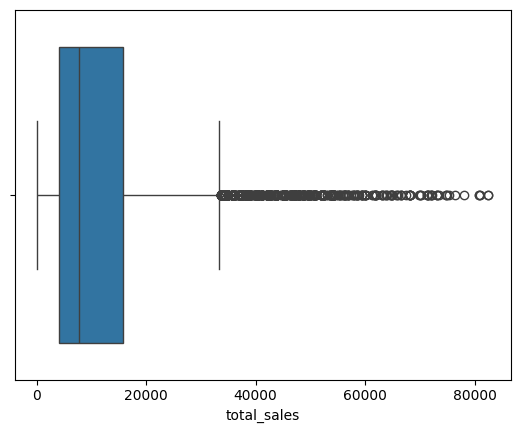

In [50]:
sns.boxplot(x=y_train)

<Axes: xlabel='total_sales', ylabel='Count'>

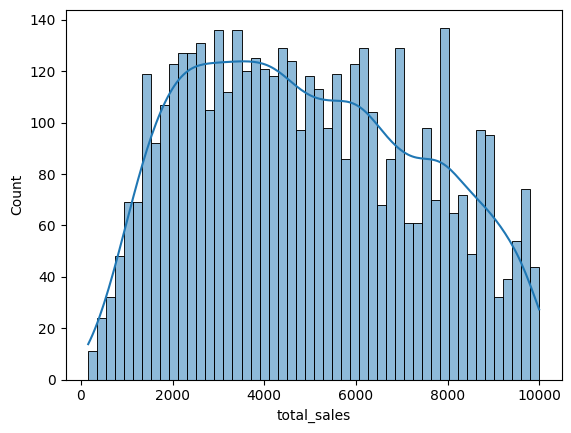

In [51]:
# Grafico hist desde los 0 a 10000
sns.histplot(y_train[y_train < 10000], bins=50, kde=True)

In [52]:
len(y_train)

7709

In [53]:
len(y_train[y_train > 45000])

260

In [54]:
len(y_train[y_train < 500])

27

- Estuve visualizando los valores de mi target. Me di cuenta de que tenia muchos valores extremos. **Negocio** aqui es importante, porque mi decisión fue quedarme con los máximos datos posibles pero aún asi probé de todas las formas.

-------------------

- Pensé en imputar la mediana al target para que tuviera unos valores mas concentrados y no tan dispersos. Tenía una larga cola al final y eso podría perjudicarme.

In [55]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_no_outliers = y_train[(y_train >= lower_bound) & (y_train <= upper_bound)].median()
print(f"La mediana es de {median_no_outliers}")

y_train_imputed = y_train.copy()
y_train_imputed[(y_train < lower_bound) | (y_train > upper_bound)] = median_no_outliers

y_test_imputed = y_test.copy()
y_test_imputed[(y_test < lower_bound) | (y_test > upper_bound)] = median_no_outliers

La mediana es de 7000.0


In [56]:
y_train_imputed.describe()


count     7709.000000
mean      9265.476586
std       7304.726214
min        160.000000
25%       4080.000000
50%       7000.000000
75%      12000.000000
max      33250.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales', ylabel='Count'>

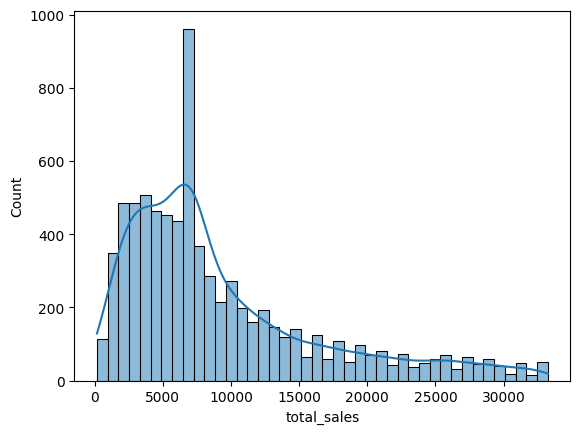

In [57]:
sns.histplot(y_train_imputed, kde = True)

- Cuando vi esto, pensé que era algo negativo para cualquier modelo. No quiero que tenga exceso de valores en una zona que yo mismo he imputado.

🙋‍♂️ Opción rechazada

----------

- Capping / Windsorizing era mi siguiente propuesta. 

In [58]:
upper_cap = y_train.quantile(0.95)
y_train_capped = y_train.copy()
y_train_capped[y_train_capped > upper_cap] = upper_cap

y_test_capped = y_test.copy()
y_test_capped[y_test_capped > upper_cap] = upper_cap

In [59]:
y_train_capped.describe()

count     7709.000000
mean     11829.161889
std      10853.102480
min        160.000000
25%       4080.000000
50%       7791.000000
75%      15750.000000
max      40450.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales', ylabel='Count'>

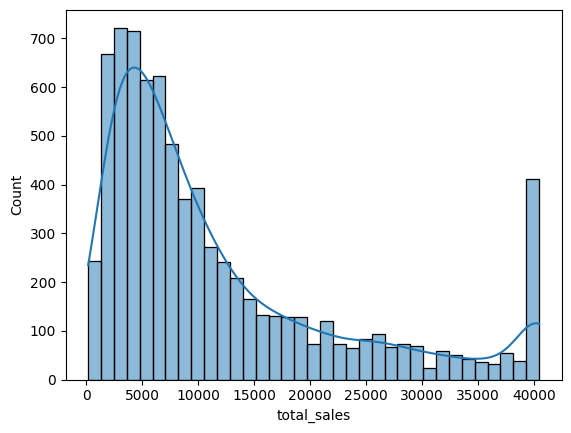

In [60]:
sns.histplot(y_train_capped, kde = True)

- Tenía buena esperanza en este método pero me hace algo parecido al anterior. Me genera una zona con una cantidad de valores imputados por mi y que no sigue la naturaleza del gráfico.

🙋‍♂️ Opción rechazada

---------------

🔎 DESPUÉS DE TANTAS PRUEBAS:

Realicé numerosas pruebas, pensé que los valores por encima de 45k euros que son 260 filas y representaban el 3% del dataset... eran los que generaban ruido. Pero cuando realicé las pruebas del modelo pude ver que la mejora era muy pequeña y no consideraba necesario perder información para luego no mejorar de forma notable.

*Siempre hay que tener un contexto real y en el entorno real surgen estas mismas decisiones*

MOMENTO NEGOCIO

- Considero que los valores que si hacían ruido eran los más extremos. Aun asi, esto seria algo para comentar con los jefes de equipo.

In [61]:
# Eliminamos los outliers
mask_train = y_train <= 80000
X_train_filtered = X_train[mask_train]
y_train_filtered = y_train[mask_train]

In [62]:
mask_train_2 = y_train >= 300
X_train_filtered = X_train_filtered[mask_train_2]
y_train_filtered = y_train_filtered[mask_train_2]

C:\Users\lukat\AppData\Local\Temp\ipykernel_7376\3718196299.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_filtered = X_train_filtered[mask_train_2]


In [63]:
y_train_filtered.describe()

count     7697.000000
mean     12344.566065
std      12507.313632
min        320.000000
25%       4092.000000
50%       7791.000000
75%      15750.000000
max      78000.000000
Name: total_sales, dtype: float64

In [64]:
# Eliminamos los outliers del X_train_df donde tenia el Column Transform
X_train_df_mask = X_train_df[mask_train]
X_train_df_mask = X_train_df_mask[mask_train_2]

C:\Users\lukat\AppData\Local\Temp\ipykernel_7376\1898312544.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_df_mask = X_train_df_mask[mask_train_2]


In [65]:
X_train_filtered

,retailer,region,state,product,price_per_unit,month,day_of_week
485,West Gear,Southeast,Florida,Men's Apparel,60.0,4,4
6472,Sports Direct,South,Texas,Men's Apparel,26.0,8,6
1222,Foot Locker,Midwest,Minnesota,Men's Apparel,35.0,12,1
5608,West Gear,Northeast,New York,Women's Apparel,66.0,7,3
2855,Kohl's,Midwest,Montana,Women's Apparel,55.0,3,1
...,...,...,...,...,...,...,...
5734,Kohl's,Midwest,Kansas,Men's Athletic Footwear,49.0,7,0
5191,Sports Direct,Midwest,Michigan,Women's Street Footwear,41.0,6,3
5390,West Gear,West,Oregon,Men's Apparel,86.0,6,3
860,Walmart,South,Texas,Men's Apparel,45.0,8,6


In [66]:
X_train_df_mask

,price_per_unit,retailer_Amazon,retailer_Foot_Locker,retailer_Kohl's,retailer_Sports_Direct,retailer_Walmart,retailer_West_Gear,region_Midwest,region_Northeast,region_South,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
485,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6472,26.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1222,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5608,66.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2855,55.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,49.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5191,41.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,86.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
860,45.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


- Tenemos dos conjuntos de entrenamientos: **X_train_df_mask** (7697 x 87) y **X_train_filtered** (7697 x 7)

- Para transformar el target, pensé en una logarítmica pero leí sobre Box-Cox y me gustó más porque intentaba que los datos se parecieran lo más posible a una distribución gaussiana.

In [67]:
# box-cox transformation
y_train_boxcox, lambda_val = boxcox(y_train_filtered)

# lambda_val es el parámetro óptimo calculado para la transformación.
print(f"Lambda óptima: {lambda_val}")

Lambda óptima: 0.0286196604600691


In [68]:
# en test aplicamos el mismo boxcox que en train
y_test_boxcox = boxcox(y_test, lmbda=lambda_val)


<Axes: ylabel='Count'>

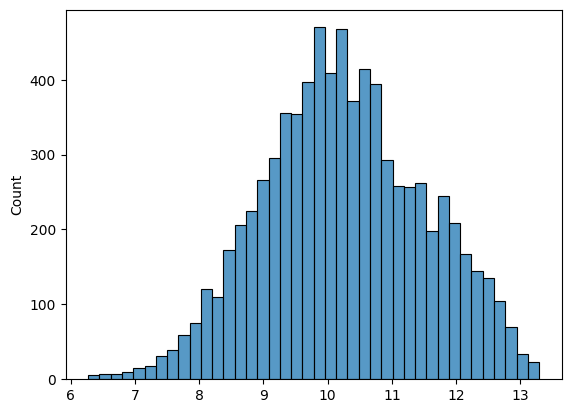

In [69]:
sns.histplot(y_train_boxcox)

- Efectivamente se ve bastante mejor. Nos quedamos con el Box-Cox

- Aquí el ejemplo de la logaritmica:

In [70]:
y_train_log = np.log1p(y_train_filtered)
y_test_log = np.log1p(y_test)

<Axes: xlabel='total_sales', ylabel='Count'>

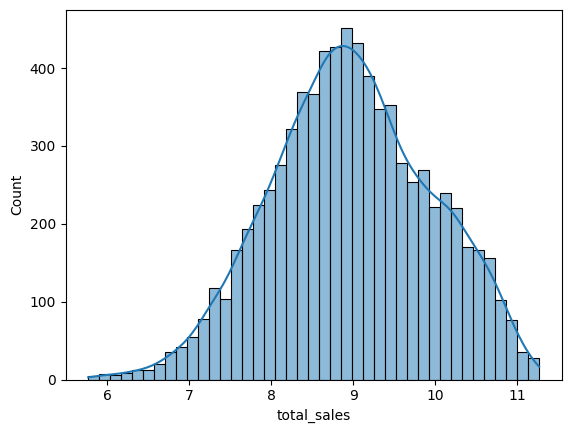

In [71]:
sns.histplot(y_train_log, kde = True)

- No era mala opción del todo pero en una prueba que hice el Box-Cox me dio mejor resultado

# ✅ Step 6: Selección e instanciación de modelos. Baseline.


- Dejamos unas funciones cargadas para utilizar en los siguientes pasos:

In [76]:
def rmse_boxcox_inverse(y_true_boxcox, y_pred_boxcox):
    y_true_original = inv_boxcox(y_true_boxcox, lambda_val)
    y_pred_original = inv_boxcox(y_pred_boxcox, lambda_val)
    
    return np.sqrt(mean_squared_error(y_true_original, y_pred_original))

scorer = make_scorer(rmse_boxcox_inverse, greater_is_better=False)

In [73]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer_tradi = make_scorer(rmse, greater_is_better=False)

**LINEAR REGRESSION**

In [ ]:
# Entrenar el modelo de regresión lineal
baseline_model = LinearRegression()
baseline_model.fit(X_train_df_mask, y_train_boxcox)

# Predecir en el conjunto de prueba
y_pred_boxcox_baseline = baseline_model.predict(X_test_df)

y_pred_baseline = inv_boxcox(y_pred_boxcox_baseline, lambda_val)

# Evaluar el modelo
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"RMSE: {rmse_baseline}")
print(f"MAE: {mae_baseline}")
print(f"R2: {r2_baseline}")

RMSE: 9567.018616260499
MAE: 6526.151476851045
R2: 0.4605487539505192


- Tuve un resultado con bastante error y quise seguir probando otros modelos.

**MLP REGRESSOR**

In [104]:
from sklearn.neural_network import MLPRegressor

# Entrenar el modelo de red neuronal
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train_df_mask, y_train_boxcox)

# Predecir en el conjunto de prueba
y_pred_nn = nn_model.predict(X_test_df)
y_pred_nn = inv_boxcox(y_pred_nn, lambda_val)

# Evaluar el modelo
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - RMSE: {rmse_nn:.2f}")
print(f"Neural Network - MAE: {mae_nn:.2f}")
print(f"Neural Network - R2: {r2_nn:.4f}")

Neural Network - RMSE: 9204.82
Neural Network - MAE: 6488.44
Neural Network - R2: 0.5006


- Resultado muy parecido al anterior aunque mejoramos algo de R2.

**CATBOOST**

Nuestro train aqui es **X_train_filtered** que contiene 7 columnas. **CatBoost** es un buen modelo cuando tenemos features categoricas.

In [74]:
# Entrenamos el modelo con los datos transformados
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)

# Realizamos predicciones en el conjunto de prueba
y_pred_boxcox_cat = cat_model.predict(X_test)
y_pred = inv_boxcox(y_pred_boxcox_cat, lambda_val)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

RMSE: 5370.497427175011
MAE: 3174.3682626004233
R2: 0.8300081938668566


- Gran resultado. Buen R2. El RMSE queda alto en parte por nuestro target que tiene valores con mucha distancia. 

🧠 APTO para avanzar con este modelo

**RANDOM FOREST**

- Aqui tenemos **X_train_df_mask** contiene 87 columnas porque tenia el OneHotEncoder de nuestro Column Transform

In [106]:
# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_df_mask, y_train_boxcox)

# Predecir en el conjunto de prueba
y_pred_boxcox_rf = rf_model.predict(X_test_df)
y_pred_rf = inv_boxcox(y_pred_boxcox_rf, lambda_val)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rmse_rf:.2f}")
print(f"Random Forest - MAE: {mae_rf:.2f}")
print(f"Random Forest - R2: {r2_rf:.4f}")

Random Forest - RMSE: 5781.40
Random Forest - MAE: 3381.82
Random Forest - R2: 0.8030


- Tenemos buen R2 pero el RMSE es más alto comparandolo con **CATBOOST**

🧠 APTO para avanzar con este modelo

**XGBOOST**

- Aqui tenemos **X_train_df_mask** contiene 87 columnas porque tenia el OneHotEncoder de nuestro Column Transform

In [102]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_df_mask, y_train_boxcox)

y_pred_boxcox_xgb = xgb_model.predict(X_test_df)
y_pred_xgb = inv_boxcox(y_pred_boxcox_xgb, lambda_val)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb:.2f}")
print(f"XGBoost - MAE: {mae_xgb:.2f}")
print(f"XGBoost - R2: {r2_xgb:.4f}")

XGBoost - RMSE: 5581.70
XGBoost - MAE: 3226.56
XGBoost - R2: 0.8164


- Buen resultado en general. Muy similar al **CATBOOST**

🧠 APTO para avanzar con este modelo

# ✅ Step 7: Comparación de modelos - Hiperparametros.


In [109]:
resultados_basics = pd.DataFrame({
    "Modelo": [
        "Linear Regression",
        "MLP Regression",
        "CatBoost",
        "Random Forest",
        "XGBoost",
    ],
    "RMSE": [
        rmse_baseline,
        rmse_nn,
        rmse,
        rmse_rf,
        rmse_xgb,
    ],
    "MAE": [
        mae_baseline,
        mae_nn,
        mae,
        mae_rf,
        mae_xgb,
    ],
    "R2": [
        r2_baseline,
        r2_nn,
        r2,
        r2_rf,
        r2_xgb,
    ]
})

resultados_basics[["RMSE", "MAE", "R2"]] = resultados_basics[["RMSE", "MAE", "R2"]].round(3)

# Vista rápida de la tabla
print(resultados_basics)


              Modelo      RMSE       MAE     R2
0  Linear Regression  9567.019  6526.151  0.461
1     MLP Regression  9204.822  6488.441  0.501
2           CatBoost  5356.213  3168.824  0.831
3      Random Forest  5781.401  3381.815  0.803
4            XGBoost  5581.703  3226.555  0.816


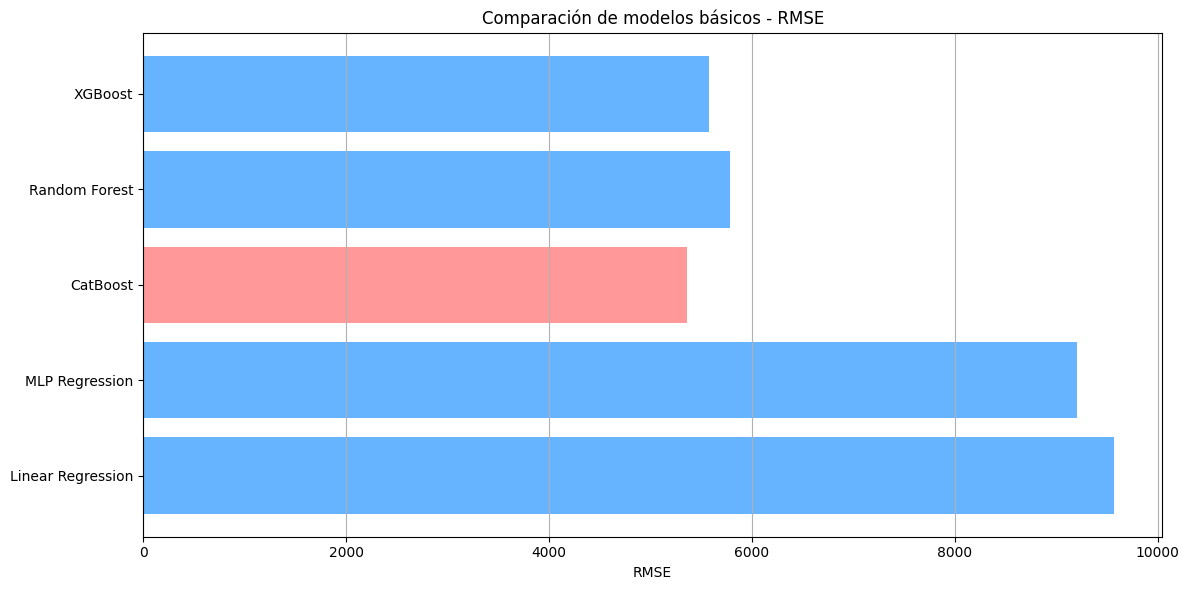

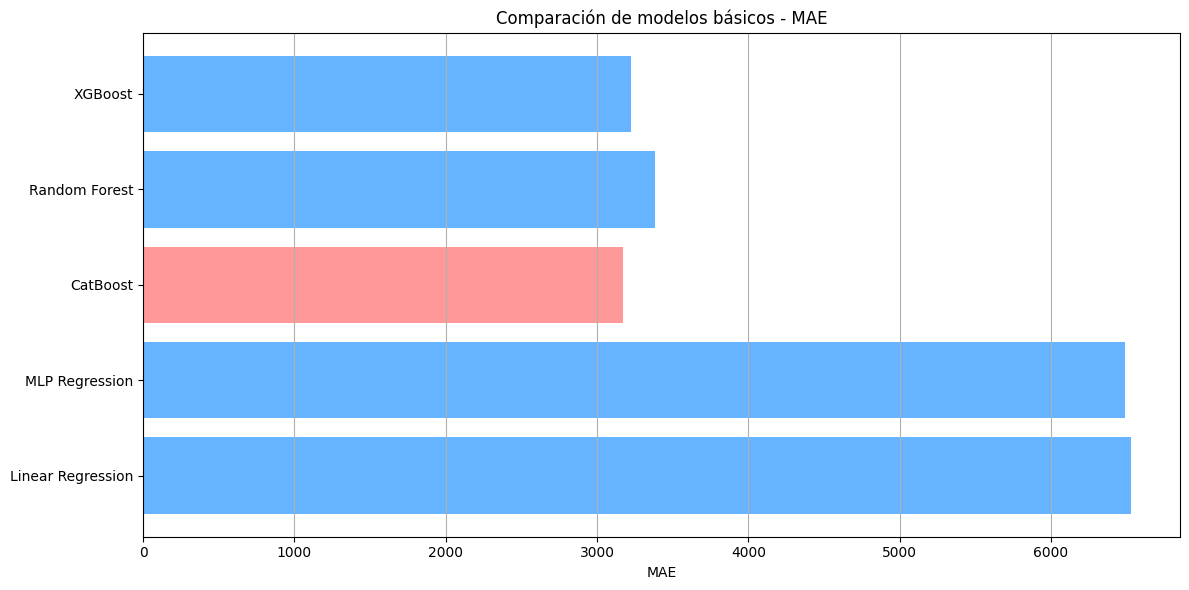

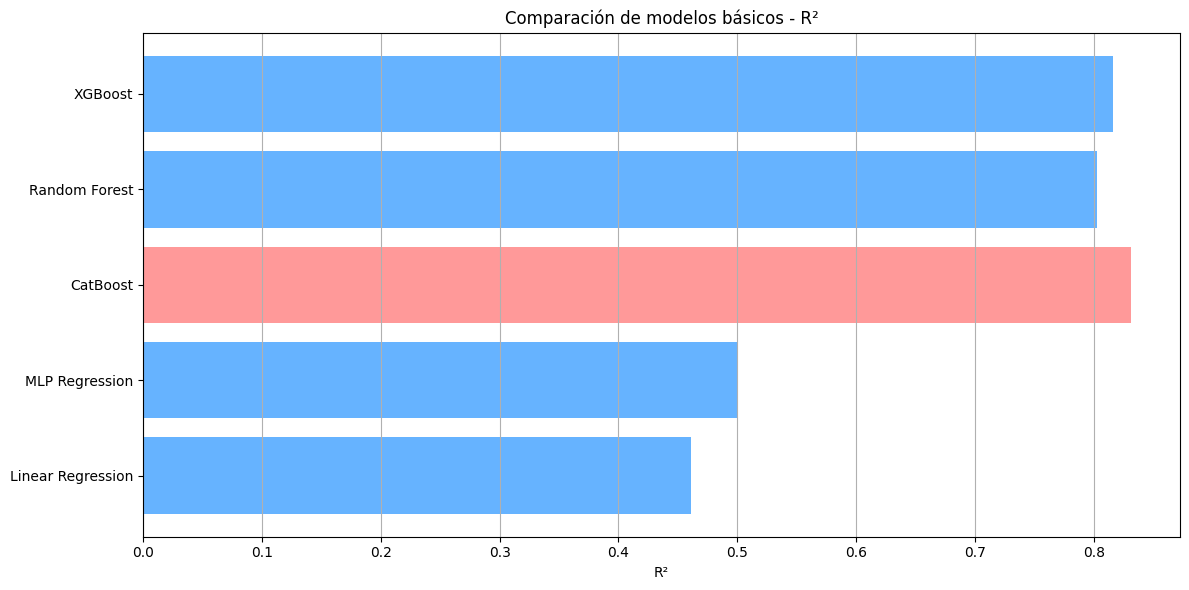

In [110]:
# Pintamos para ver los resultados
best_rmse_idx = resultados_basics["RMSE"].idxmin()
best_mae_idx = resultados_basics["MAE"].idxmin()
best_r2_idx = resultados_basics["R2"].idxmax()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_rmse_idx else '#66B3FF' for i in range(len(resultados_basics))]
plt.barh(resultados_basics["Modelo"], resultados_basics["RMSE"], color=colors)
plt.xlabel("RMSE")
plt.title("Comparación de modelos básicos - RMSE")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_mae_idx else '#66B3FF' for i in range(len(resultados_basics))]
plt.barh(resultados_basics["Modelo"], resultados_basics["MAE"], color=colors)
plt.xlabel("MAE")
plt.title("Comparación de modelos básicos - MAE")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_r2_idx else '#66B3FF' for i in range(len(resultados_basics))]
plt.barh(resultados_basics["Modelo"], resultados_basics["R2"], color=colors)
plt.xlabel("R²")
plt.title("Comparación de modelos básicos - R²")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

- Viendo la comparativa. Se ve que **CATBOOST** fue el mejor modelo baseline-basico. **XGBOOST** tiene gran potencial y **RF** se queda algo atrás pero le daremos una oportunidad.

---------

- Búsqueda de hiperparametros **GRIDSEARCH** y **RANDOMIZEDSEARCH**

**CATBOOST**

In [79]:
# CATBOOST GRIDSEARCH

param_grid = {
    "depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
    "iterations": [300, 500, 700],
    "l2_leaf_reg": [1, 3, 5]
}

grid_cat = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=1 # en portatil tenia que utilizar 1, en mi PC podia utilizar -1
)

grid_cat.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)

best_model_cat = grid_cat.best_estimator_

# Mejores hiperparametros
print(f"Mejores hiperparametros: {grid_cat.best_params_}")
print(f"Mejor score RMSE: {-grid_cat.best_score_}")

# Predecir en el conjunto de prueba
y_pred_boxcox_gridcat = best_model_cat.predict(X_test)
y_pred_grid_cat = inv_boxcox(y_pred_boxcox_gridcat, lambda_val)

# Evaluar el modelo
mse_grid_cat = mean_squared_error(y_test, y_pred_grid_cat)
rmse_grid_cat = np.sqrt(mse_grid_cat)
mae_grid_cat = mean_absolute_error(y_test, y_pred_grid_cat)
r2_grid_cat = r2_score(y_test, y_pred_grid_cat)

print(f"RMSE GridSearch CatBoost: {rmse_grid_cat:2f}")
print(f"MAE GridSearch CatBoost: {mae_grid_cat:.2f}")
print(f"R2 GridSearch CatBoost: {r2_grid_cat:4f}")

KeyboardInterrupt: 

In [113]:
# CATBOOST RANDOMIZEDSEARCH
param_dist_cat = {
    "depth": [3,4,5,6,7],
    "learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5],
    "iterations": [300, 500,700, 1000],
    "l2_leaf_reg": [1, 3, 5, 7]
}

random_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_distributions=param_dist_cat,
    n_iter=30,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)

best_model_random = random_search.best_estimator_

# Mejores hiperparámetros
print(f"Mejores hiperparametros: {random_search.best_params_}")
print(f"Mejor score RMSE: {-random_search.best_score_}")

# Predecir en el conjunto de prueba
y_pred_boxcox_random = best_model_random.predict(X_test)
y_pred_random = inv_boxcox(y_pred_boxcox_random, lambda_val)

# Evaluar el modelo
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)

print(f"RMSE RandomSearch CatBoost: {rmse_random:2f}")
print(f"MAE RandomSearch CatBoost: {mae_random:.2f}")
print(f"R2 RandomSearch CatBoost: {r2_random:4f}")



Mejores hiperparametros: {'learning_rate': 0.3, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6}
Mejor score RMSE: 5512.113412613679
RMSE RandomSearch CatBoost: 5290.786938
MAE RandomSearch CatBoost: 3058.74
R2 RandomSearch CatBoost: 0.835017


**RANDOM FOREST**

In [114]:
# RF GRIDSEARCH

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_df_mask, y_train_boxcox)
best_model_rf = grid_search.best_estimator_

# Mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor score RMSE: {-grid_search.best_score_:.2f}")

# Predecir en el conjunto de prueba
y_pred_boxcox_grid_rf = grid_search.predict(X_test_df)
y_pred_grid_rf = inv_boxcox(y_pred_boxcox_grid_rf, lambda_val)

# Evaluar el modelo
mse_grid_rf = mean_squared_error(y_test, y_pred_grid_rf)
rmse_grid_rf = np.sqrt(mse_grid_rf)
mae_grid_rf = mean_absolute_error(y_test, y_pred_grid_rf)
r2_grid_rf = r2_score(y_test, y_pred_grid_rf)

print(f"Random Forest (GridSearch)")
print(f"RMSE: {rmse_grid_rf}")
print(f"MAE: {mae_grid_rf}")
print(f"R2: {r2_grid_rf}")


Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor score RMSE: 6208.17
Random Forest (GridSearch)
RMSE: 5786.688137892891
MAE: 3382.628031980468
R2: 0.8026400085818901


In [115]:
# RF RandomizedSearch

param_dist_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=30,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    random_state=42
)
random_search_rf.fit(X_train_df_mask, y_train_boxcox)
best_model_rf_random = random_search_rf.best_estimator_
best_params_rf_random = random_search_rf.best_params_
print(f"Mejores hiperparámetros RF (RandomizedSearch): {best_params_rf_random}")
print(f"Mejor score RMSE RF (RandomizedSearch): {-random_search_rf.best_score_:.2f}")

# Predecir en el conjunto de prueba
y_pred_boxcox_rf_random = random_search_rf.predict(X_test_df)
y_pred_rf_random = inv_boxcox(y_pred_boxcox_rf_random, lambda_val)

# Evaluar el modelo
mse_rf_random = mean_squared_error(y_test, y_pred_rf_random)
rmse_rf_random = np.sqrt(mse_rf_random)
mae_rf_random = mean_absolute_error(y_test, y_pred_rf_random)
r2_rf_random = r2_score(y_test, y_pred_rf_random)

print(f"Random Forest (RandomizedSearch)")
print(f"RMSE: {rmse_rf_random:.2f}")
print(f"MAE: {mae_rf_random:.2f}")
print(f"R2: {r2_rf_random:.4f}")

Mejores hiperparámetros RF (RandomizedSearch): {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Mejor score RMSE RF (RandomizedSearch): 6210.70
Random Forest (RandomizedSearch)
RMSE: 5800.95
MAE: 3390.54
R2: 0.8017


**XGBOOST**

In [116]:
# XGBOOST GRIDSEARCH

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.2, 0.3],
    'max_depth': [4, 5, 6]
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator= XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=-1
)
grid_search.fit(X_train_df_mask, y_train_boxcox)

best_model_xgb = grid_search.best_estimator_

# Mejores hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor score RMSE: {-grid_search.best_score_:.2f}")

# Predecir con el mejor modelo
y_pred_boxcox_grid_xgb = grid_search.predict(X_test_df)
y_pred_grid_xgb = inv_boxcox(y_pred_boxcox_grid_xgb, lambda_val)

# Evaluar el modelo
mse_grid_xgb = mean_squared_error(y_test, y_pred_grid_xgb)
rmse_grid_xgb = np.sqrt(mse_grid_xgb)
mae_grid_xgb = mean_absolute_error(y_test, y_pred_grid_xgb)
r2_grid_xgb = r2_score(y_test, y_pred_grid_xgb)

print(f"XGBoost (GridSearch)")
print(f"RMSE: {rmse_grid_xgb:.2f}")
print(f"MAE: {mae_grid_xgb:.2f}")
print(f"R2: {r2_grid_xgb:.4f}")

Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
Mejor score RMSE: 5422.98
XGBoost (GridSearch)
RMSE: 5230.24
MAE: 3103.95
R2: 0.8388


In [117]:
# XGBOOST RANDOMIZEDSEARCH

param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [4, 5, 6, 7]
}

random_search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=30,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_df_mask, y_train_boxcox)

best_model_xgb_random = random_search_xgb.best_estimator_
best_params_xgb_random = random_search_xgb.best_params_

print(f"Mejores hiperparámetros XGBoost (RandomizedSearch): {best_params_xgb_random}")
print(f"Mejor score RMSE XGBoost (RandomizedSearch): {-random_search_xgb.best_score_:.2f}")

# Predecir en el conjunto de prueba
y_pred_boxcox_xgb_random = random_search_xgb.predict(X_test_df)
y_pred_xgb_random = inv_boxcox(y_pred_boxcox_xgb_random, lambda_val)

# Evaluar el modelo
mse_xgb_random = mean_squared_error(y_test, y_pred_xgb_random)
rmse_xgb_random = np.sqrt(mse_xgb_random)
mae_xgb_random = mean_absolute_error(y_test, y_pred_xgb_random)
r2_xgb_random = r2_score(y_test, y_pred_xgb_random)

print(f"XGBoost (RandomizedSearch)")
print(f"RMSE: {rmse_xgb_random:.2f}")
print(f"MAE: {mae_xgb_random:.2f}")
print(f"R2: {r2_xgb_random:.4f}")

Mejores hiperparámetros XGBoost (RandomizedSearch): {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.3}
Mejor score RMSE XGBoost (RandomizedSearch): 5446.50
XGBoost (RandomizedSearch)
RMSE: 5242.99
MAE: 3054.34
R2: 0.8380


In [118]:
resultados_hiperparametros = pd.DataFrame({
    "Modelo": [
        "CatBoost GridSearch",
        "CatBoost RandomizedSearch",
        "Random Forest GridSearch",
        "Random Forest RandomizedSearch",
        "Xboost GridSearch",
        "Xboost RandomizedSearch",
    ],
    "RMSE": [
        rmse_grid_cat,
        rmse_random,
        rmse_grid_rf,
        rmse_rf_random,
        rmse_grid_xgb,
        rmse_xgb_random
    ],
    "MAE": [
        mae_grid_cat,
        mae_random,
        mae_grid_rf,
        mae_rf_random,
        mae_grid_xgb,
        mae_xgb_random
    ],
    "R2": [
        r2_grid_cat,
        r2_random,
        r2_grid_rf,
        r2_rf_random,
        r2_grid_xgb,
        r2_xgb_random
    ]
})
# Redondeamos
resultados_hiperparametros[["RMSE", "MAE", "R2"]] = resultados_hiperparametros[["RMSE", "MAE", "R2"]].round(3)
# Vista rápida de la tabla
print(resultados_hiperparametros)

                           Modelo      RMSE       MAE     R2
0             CatBoost GridSearch  5260.051  3136.048  0.837
1       CatBoost RandomizedSearch  5290.787  3058.736  0.835
2        Random Forest GridSearch  5786.688  3382.628  0.803
3  Random Forest RandomizedSearch  5800.952  3390.540  0.802
4               Xboost GridSearch  5230.238  3103.951  0.839
5         Xboost RandomizedSearch  5242.992  3054.339  0.838


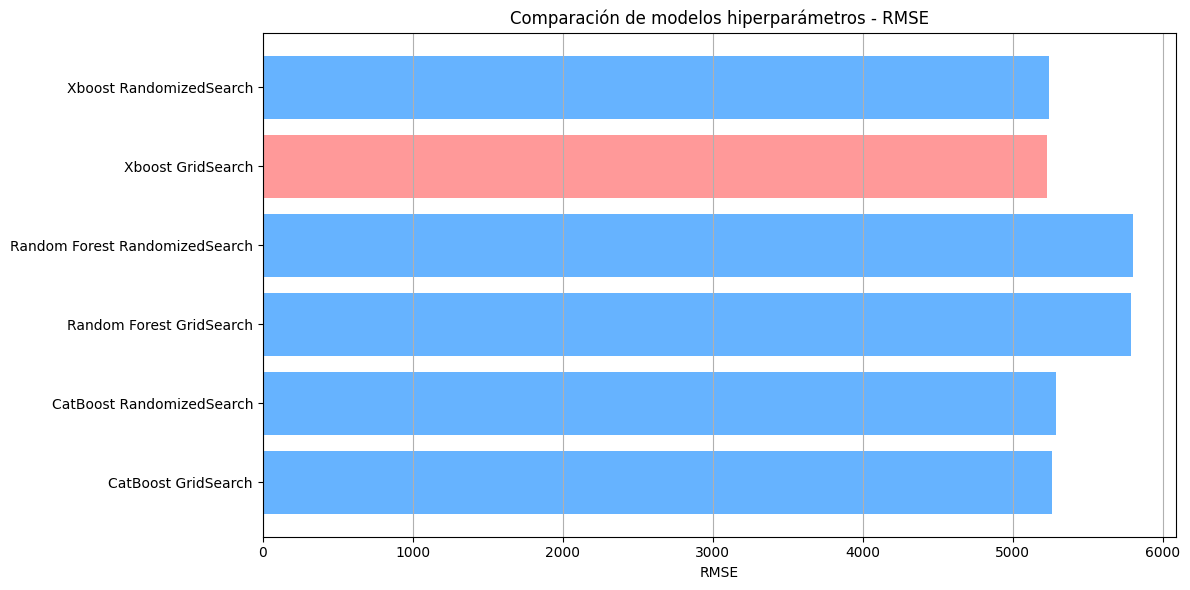

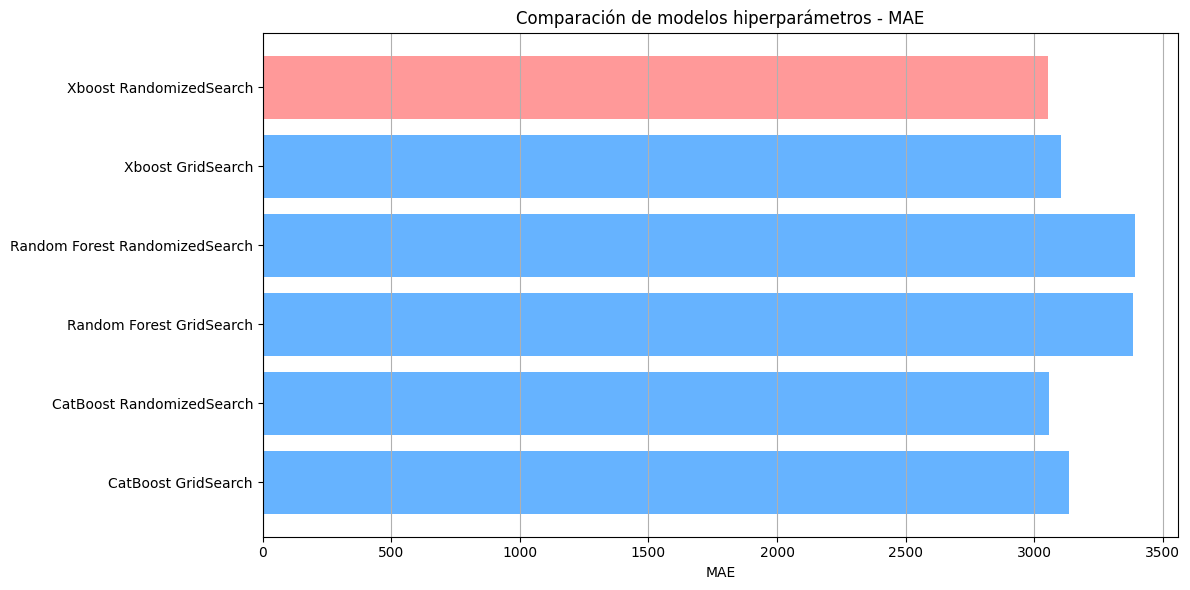

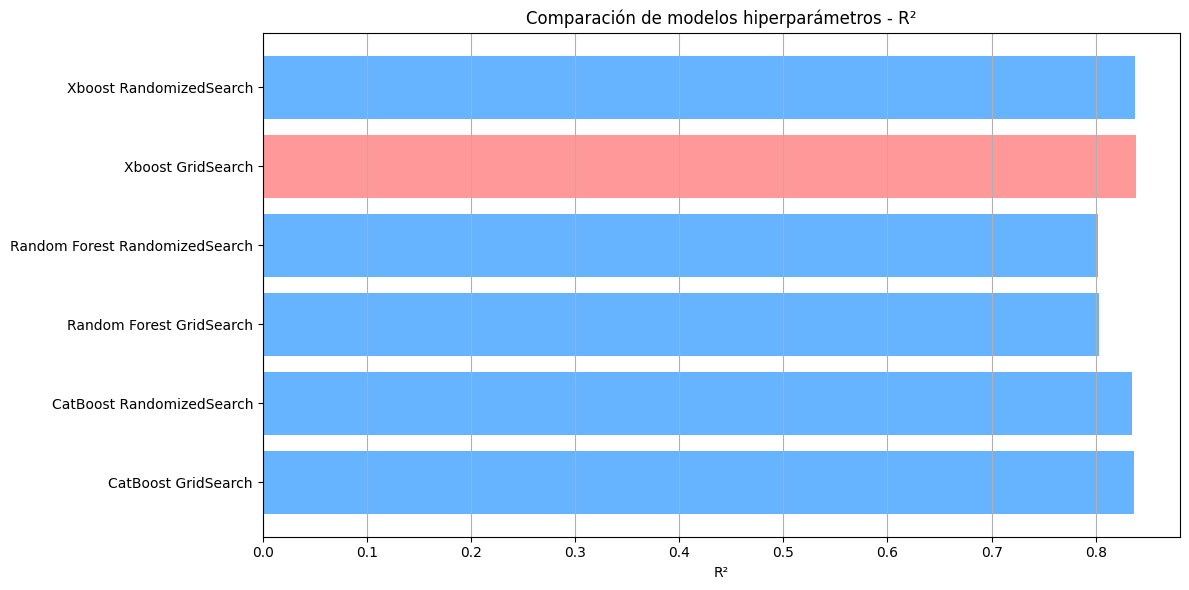

In [119]:
# Pintamos para ver los resultados

best_rmse_idx_hiper = resultados_hiperparametros["RMSE"].idxmin()
best_mae_idx_hiper = resultados_hiperparametros["MAE"].idxmin()
best_r2_idx_hiper = resultados_hiperparametros["R2"].idxmax()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_rmse_idx_hiper else '#66B3FF' for i in range(len(resultados_hiperparametros))]
plt.barh(resultados_hiperparametros["Modelo"], resultados_hiperparametros["RMSE"], color=colors)
plt.xlabel("RMSE")
plt.title("Comparación de modelos hiperparámetros - RMSE")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_mae_idx_hiper else '#66B3FF' for i in range(len(resultados_hiperparametros))]
plt.barh(resultados_hiperparametros["Modelo"], resultados_hiperparametros["MAE"], color=colors)
plt.xlabel("MAE")
plt.title("Comparación de modelos hiperparámetros - MAE")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_r2_idx_hiper else '#66B3FF' for i in range(len(resultados_hiperparametros))]
plt.barh(resultados_hiperparametros["Modelo"], resultados_hiperparametros["R2"], color=colors)
plt.xlabel("R²")
plt.title("Comparación de modelos hiperparámetros - R²")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


- Viendo que nuestro GridSearch en **CATBOOST** obtuvo mejor resultado, vamos a implementarlo en el modelo y lo evaluamos finalmente.
- **RANDOM FOREST** no ha cumplido y será descartado para el siguiente paso.
- **XGBOOST** muy interesante, rápido y ha mejorado respecto a su basico. Utilizaremos los hiperparametros de Gridsearch.

# ✅ Step 8: Evaluacion final - CATBOOST vs XGBOOST.


--------

**CATBOOST - EVALUACION FINAL**

In [122]:
# Evaluacion final

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Entrenamos el modelo con los datos transformados
cat_model = CatBoostRegressor(depth= 3, iterations=500, l2_leaf_reg= 5, learning_rate=0.5, verbose=0, random_state=42)
cat_model.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)

# Realizamos score en el conjunto de entrenamiento
score_cat_model = cat_model.score(X_train_filtered, y_train_boxcox)
print(f"Score CatBoost Inicial R2 (BoxCox no invertido): {score_cat_model:.4f}")

y_train_pred_boxcox_cat = cat_model.predict(X_train_filtered)

# Métricas en el espacio Box-Cox
train_rmse_boxcox = np.sqrt(mean_squared_error(y_train_boxcox, y_train_pred_boxcox_cat))
print(f"Entrenamiento (Box-Cox): RMSE = {train_rmse_boxcox:.2f}")

# Invertimos
y_train_pred_original = inv_boxcox(y_train_pred_boxcox_cat, lambda_val)
y_train_original = inv_boxcox(y_train_boxcox, lambda_val)

train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
train_mae = mean_absolute_error(y_train_original, y_train_pred_original)
train_r2 = r2_score(y_train_original, y_train_pred_original)
print(f"Entrenamiento (Original): RMSE = {train_rmse:.2f}, MAE = {train_mae:.2f}, R2 = {train_r2:.4f}")

# Realizamos score en el conjunto de validación manualmente
# porque kfold al hacer split, no tiene en cuenta categorical_features
cv_rmse_scores = []
cv_mae_scores = []
cv_r2_scores = []
for train_index, val_index in kf.split(X_train_filtered):
    X_train_fold = X_train_filtered.iloc[train_index]
    X_val_fold = X_train_filtered.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = CatBoostRegressor(depth= 3, iterations=500, l2_leaf_reg= 5, learning_rate=0.5, verbose=0, random_state=42)
    fold_model.fit(X_train_fold, y_train_fold, cat_features=categorical_features)

    # Predit Box Cox
    y_val_pred_boxcox_cat = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_cat, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores.append(rmse_fold)
    cv_mae_scores.append(mae_fold)
    cv_r2_scores.append(r2_fold)

print("\nValidación Cruzada (Original):")
print("RMSE por fold:", (cv_rmse_scores))
print("MAE por fold:", (cv_mae_scores))
print("R2 por fold:", (cv_r2_scores))
print("RMSE Promedio:", np.mean(cv_rmse_scores))
print("MAE Promedio:", np.mean(cv_mae_scores))
print("R2 Promedio:", np.mean(cv_r2_scores))

# Realizamos score en el conjunto de prueba
y_pred_boxcox_cat = cat_model.predict(X_test)
y_pred = inv_boxcox(y_pred_boxcox_cat, lambda_val)

mse_cat_test = mean_squared_error(y_test, y_pred)
rmse_cat_test = np.sqrt(mse)
mae_cat_test = mean_absolute_error(y_test, y_pred)
r2_cat_test = r2_score(y_test, y_pred)

print("\nTest Set (Original):")
print(f"RMSE: {rmse_cat_test:2f}")
print(f"MAE: {mae_cat_test:2f}")
print(f"R2: {r2_cat_test:.4f}")

Score CatBoost Inicial R2 (BoxCox no invertido): 0.8629
Entrenamiento (Box-Cox): RMSE = 0.46
Entrenamiento (Original): RMSE = 5080.58, MAE = 3134.64, R2 = 0.8350

Validación Cruzada (Original):
RMSE por fold: [5788.8694795577585, 5413.8676697803, 5743.834775200887, 5449.391118928253, 5311.018815527692]
MAE por fold: [3247.690047292906, 3080.5296506169325, 3438.981820168298, 3134.5497556187424, 3170.417505647456]
R2 por fold: [0.7925523964389998, 0.8085998294707365, 0.7953619530273177, 0.7937128689054365, 0.825628203943759]
RMSE Promedio: 5541.396371798978
MAE Promedio: 3214.4337558688667
R2 Promedio: 0.8031710503572498

Test Set (Original):
RMSE: 5356.212559
MAE: 3136.047537
R2: 0.8369


**XGBOOST - EVALUACION FINAL**

In [124]:
# Evaluacion final

# Kfold
kf_xgb = KFold(n_splits=5, shuffle=True, random_state=42)

# Entrenamos el modelo con los datos transformados
xgb_model = XGBRegressor(learning_rate = 0.2, max_depth = 4, n_estimators = 300, verbosity=0, random_state=42)
xgb_model.fit(X_train_df_mask, y_train_boxcox)

# Realizamos score en el conjunto de entrenamiento
score_xgb_model = xgb_model.score(X_train_df_mask, y_train_boxcox)
print(f"Score XGBoost Inicial R2 (BoxCox no invertido): {score_xgb_model:.4f}")

y_train_pred_boxcox_xgb = xgb_model.predict(X_train_df_mask)

# Métricas en el espacio Box-Cox
train_rmse_boxcox_xgb = np.sqrt(mean_squared_error(y_train_boxcox, y_train_pred_boxcox_xgb))
print(f"Entrenamiento (Box-Cox): RMSE = {train_rmse_boxcox_xgb:.2f}")

# Invertimos
y_train_pred_original_xgb = inv_boxcox(y_train_pred_boxcox_xgb, lambda_val)
y_train_original_xgb = inv_boxcox(y_train_boxcox, lambda_val)

train_rmse_xgb = np.sqrt(mean_squared_error(y_train_original_xgb, y_train_pred_original_xgb))
train_mae_xgb = mean_absolute_error(y_train_original_xgb, y_train_pred_original_xgb)
train_r2_xgb = r2_score(y_train_original_xgb, y_train_pred_original_xgb)
print(f"Entrenamiento (Original): RMSE = {train_rmse_xgb:.2f}, MAE = {train_mae_xgb:.2f}, R2 = {train_r2_xgb:.4f}")

# Realizamos score en el conjunto de validación manualmente
# simplemente por seguir la misma guia que en CATBOOST

cv_rmse_scores_xgb = []
cv_mae_scores_xgb = []
cv_r2_scores_xgb = []

for train_index, val_index in kf_xgb.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model_xgb = XGBRegressor(learning_rate = 0.2, max_depth = 4, n_estimators = 300, verbosity=0, random_state=42)
    fold_model_xgb.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_xgb = fold_model_xgb.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original_xgb = inv_boxcox(y_val_pred_boxcox_xgb, lambda_val)
    y_val_original_xgb = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold_xgb = np.sqrt(mean_squared_error(y_val_original_xgb, y_val_pred_original_xgb))
    mae_fold_xgb = mean_absolute_error(y_val_original_xgb, y_val_pred_original_xgb)
    r2_fold_xgb = r2_score(y_val_original_xgb, y_val_pred_original_xgb)

    cv_rmse_scores_xgb.append(rmse_fold_xgb)
    cv_mae_scores_xgb.append(mae_fold_xgb)
    cv_r2_scores_xgb.append(r2_fold_xgb)

print("\nValidación Cruzada (Original):")
print("RMSE por fold:", (cv_rmse_scores_xgb))
print("MAE por fold:", (cv_mae_scores_xgb))
print("R2 por fold:", (cv_r2_scores_xgb))
print("RMSE Promedio:", np.mean(cv_rmse_scores_xgb))
print("MAE Promedio:", np.mean(cv_mae_scores_xgb))
print("R2 Promedio:", np.mean(cv_r2_scores_xgb))

# Realizamos score en el conjunto de prueba
y_pred_boxcox_xgb = xgb_model.predict(X_test_df)
y_pred_xgb = inv_boxcox(y_pred_boxcox_xgb, lambda_val)

mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb_test = np.sqrt(mse_xgb)
mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb_test = r2_score(y_test, y_pred_xgb)

print("\nTest Set (Original):")
print(f"RMSE: {rmse_xgb_test:.2f}")
print(f"MAE: {mae_xgb_test:.2f}")
print(f"R2: {r2_xgb_test:.4f}")


Score XGBoost Inicial R2 (BoxCox no invertido): 0.9055
Entrenamiento (Box-Cox): RMSE = 0.39
Entrenamiento (Original): RMSE = 4124.31, MAE = 2430.59, R2 = 0.8912

Validación Cruzada (Original):
RMSE por fold: [5791.127090719666, 5333.752988790327, 5875.888852827113, 5592.111836491229, 5302.723453065917]
MAE por fold: [3216.550428157659, 3087.5354583740236, 3386.413328928016, 3148.351726569164, 3084.0157704294465]
R2 por fold: [0.792390559192349, 0.8142226145687974, 0.7858442944899224, 0.7827659628672986, 0.8261724865622171]
RMSE Promedio: 5579.120844378851
MAE Promedio: 3184.573342491662
R2 Promedio: 0.8002791835361169

Test Set (Original):
RMSE: 5581.70
MAE: 3103.95
R2: 0.8388


---------

Evolucion de **CATBOOST** y **XGBOOST**

In [125]:
print(f"--- XGBoost ---")
print(f"RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.4f}")

print(f"--- XGBoost GridSearch ---")
print(f"RMSE: {rmse_grid_xgb:.2f}, MAE: {mae_grid_xgb:.2f}, R²: {r2_grid_xgb:.4f}")

print(f"--- XGBoost RandomizedSearch ---")
print(f"RMSE: {rmse_xgb_random:.2f}, MAE: {mae_xgb_random:.2f}, R²: {r2_xgb_random:.4f}")

print(f"--- CatBoost ---")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

print(f"--- CatBoost GridSearch ---")
print(f"RMSE: {rmse_grid_cat:.2f}, MAE: {mae_grid_cat:.2f}, R²: {r2_grid_cat:.4f}")

print(f"--- CatBoost RandomizedSearch ---")
print(f"RMSE: {rmse_random:.2f}, MAE: {mae_random:.2f}, R²: {r2_random:.4f}")

--- XGBoost ---
RMSE: 5581.70, MAE: 3226.56, R²: 0.8164
--- XGBoost GridSearch ---
RMSE: 5230.24, MAE: 3103.95, R²: 0.8388
--- XGBoost RandomizedSearch ---
RMSE: 5242.99, MAE: 3054.34, R²: 0.8380
--- CatBoost ---
RMSE: 5356.21, MAE: 3168.82, R²: 0.8309
--- CatBoost GridSearch ---
RMSE: 5260.05, MAE: 3136.05, R²: 0.8369
--- CatBoost RandomizedSearch ---
RMSE: 5290.79, MAE: 3058.74, R²: 0.8350


In [126]:
resultados_finales_cat = pd.DataFrame({
    "Entrenamiento": [train_rmse, train_mae, train_r2],
    "Validación": [np.mean(cv_rmse_scores), np.mean(cv_mae_scores), np.mean(cv_r2_scores)],
    "Test": [rmse_cat_test, mae_cat_test, r2_cat_test]
}, index=["RMSE", "MAE", "R"]).reset_index().rename(columns={"index": "Métrica"})

resultados_finales_xgb = pd.DataFrame({
    "Entrenamiento": [train_rmse_xgb, train_mae_xgb, train_r2_xgb],
    "Validación": [np.mean(cv_rmse_scores_xgb),np.mean(cv_mae_scores_xgb),np.mean(cv_r2_scores_xgb)],
    "Test": [rmse_xgb_test, mae_xgb_test, r2_xgb_test]
}, index=["RMSE", "MAE", "R"]).reset_index().rename(columns={"index": "Métrica"})

print(f"---CATBOOST---")
print(resultados_finales_cat)
print(f"---XGBOOST---")
print(resultados_finales_xgb)

---CATBOOST---
  Métrica  Entrenamiento   Validación         Test
0    RMSE    5080.578684  5541.396372  5356.212559
1     MAE    3134.637553  3214.433756  3136.047537
2       R       0.834973     0.803171     0.836928
---XGBOOST---
  Métrica  Entrenamiento   Validación         Test
0    RMSE    4124.307983  5579.120844  5581.703410
1     MAE    2430.585045  3184.573342  3103.950577
2       R       0.891250     0.800279     0.838772


Vemos que es super similar los resultados en **VALIDACIÓN** y **TEST**, aunque el entrenamiento de **XGBOOST** resulta muy superior

😉 EL GANADOR: **CATBOOST**

¿POR QUÉ?

- Me hubiese quedado con XGBOOST si no tuviera tanta diferencia entre el Entrenamiento y luego las Validaciones y Test. Es un gap que puede indicar sobreajuste. Esto me explica que no es capaz de generalizar tan bien como **CATBOOST** 😁

------------

In [1]:
y_pred_boxcox_global = best_model_cat.predict(X_test)
y_pred_global = inv_boxcox(y_pred_boxcox_global, lambda_val)

df_result = X_test.copy()
df_result["prediccion"] = y_pred_global

predicciones_por_tienda = df_result.groupby("tienda")["prediccion"].mean()
print(predicciones_por_tienda)

NameError: name 'best_model_cat' is not defined

# ✅ Step 10: Guardar el modelo.

In [ ]:
joblib.dump(best_model_cat, "../models/best_model_cat.pkl")

['../models/best_model_xgb.pkl']